<a href="https://colab.research.google.com/github/mattalejo/quant-stuff/blob/main/Copy_of_thesis_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download relevant libraries

In [1]:
%matplotlib inline
import mxnet as mx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ujson
import os
import sys
from itertools import islice
from pathlib import Path
import yfinance as yf

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx import TransformerEstimator, DeepAREstimator, Trainer
from gluonts.dataset.split import split
from gluonts.evaluation import make_evaluation_predictions, Evaluator

Failure when querying GPU: Traceback (most recent call last):
  File "../include/mxnet/base.h", line 458
CUDA: Check failed: e == cudaSuccess (999 vs. 0) : unknown error


# Import necessary libraries

In [2]:
# import yfinance as yf
# from matplotlib import pyplot as plt

# import numpy as np
# import pandas as pd
# import math as m

# from sklearn.preprocessing import StandardScaler
# from tensorboard_logger import configure

# import copy
# import sys
# import os

# sys.path.append('/content/Date2Vec')
# sys.path.append('/content/transformers')

In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.utils.data as data
# from torch.utils.data import Dataset, DataLoader, TensorDataset

# from Experiment import Date2VecExperiment
# from Model import Date2Vec, Date2VecConvert

# from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction

In [4]:
# if torch.cuda.is_available():
#  dev = "cuda:0"
# else:
#  dev = "cpu"
# device = torch.device(dev)

# print(dev)

# Load data

In [5]:
asean_exchanges = ["PSEI.PS"]

In [6]:
start_date = '2000-1-1'
end_date = '2022-12-31'

In [7]:
raw_data = yf.download(asean_exchanges, start_date,end_date)
idx = pd.date_range(start_date, end_date)
raw_data_ffill = raw_data.reindex(idx, method='ffill')
raw_data_ffill.tail()
raw_data_ffill.shape

def ffill(x):
  return 1 if x in list(raw_data.index) else 0


ffill_truth = list(map(ffill, list(raw_data_ffill.index)))

[*********************100%%**********************]  1 of 1 completed


In [8]:
raw_data_ffill["Filled?"] = ffill_truth
raw_data_ffill

,Open,High,Low,Close,Adj Close,Volume,Filled?
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0
2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0
2000-01-03,2143.669922,2148.709961,2122.989990,2141.770020,2141.219482,0.0,1
2000-01-04,2151.550049,2158.209961,2130.679932,2153.179932,2152.626465,0.0,1
2000-01-05,2113.379883,2113.379883,2070.139893,2074.750000,2074.216553,0.0,1
...,...,...,...,...,...,...,...
2022-12-27,6549.089844,6579.259766,6519.899902,6564.899902,6564.899902,75400.0,1
2022-12-28,6567.129883,6576.709961,6530.270020,6566.540039,6566.540039,88600.0,1
2022-12-29,6553.669922,6591.279785,6529.689941,6566.390137,6566.390137,161100.0,1
2022-12-30,6553.669922,6591.279785,6529.689941,6566.390137,6566.390137,161100.0,0


In [9]:
log_returns_raw = pd.DataFrame(np.log(raw_data_ffill['Adj Close']/raw_data_ffill['Adj Close'].shift(1)).dropna())
log_returns_raw.columns = ["Log Returns"]
returns_raw = raw_data['Adj Close'].pct_change().dropna()

log_returns = log_returns_raw.join(raw_data_ffill["Filled?"], how="left")
log_returns

,Log Returns,Filled?
2000-01-04,0.005313,1
2000-01-05,-0.037105,1
2000-01-06,0.002099,1
2000-01-07,0.007275,1
2000-01-08,0.000000,0
...,...,...
2022-12-27,0.003643,1
2022-12-28,0.000250,1
2022-12-29,-0.000023,1
2022-12-30,0.000000,0


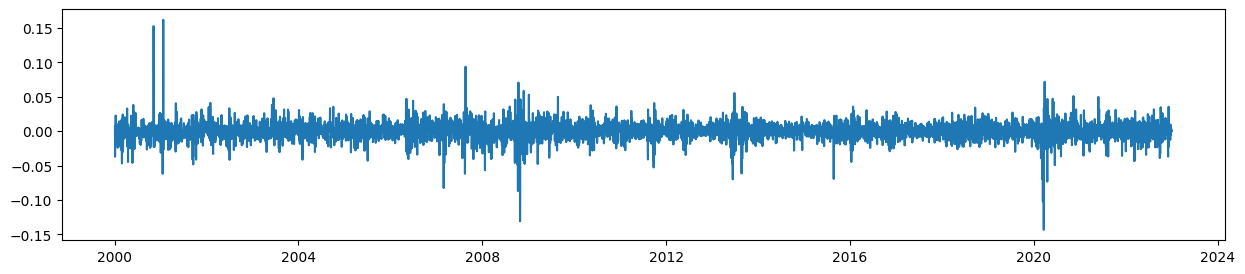

In [10]:
plt.figure(figsize=(15,3))
plt.plot(log_returns["Log Returns"])

In [11]:
a = pd.DataFrame(log_returns["Log Returns"].rolling(7).mean(), columns=["7d"])
a["15d"] = log_returns["Log Returns"].rolling(15).mean()
a["30d"] = log_returns["Log Returns"].rolling(30).mean()
a["90d"] = log_returns["Log Returns"].rolling(90).mean()
a["180d"] = log_returns["Log Returns"].rolling(180).mean()
a["360d"] = log_returns["Log Returns"].rolling(360).mean()

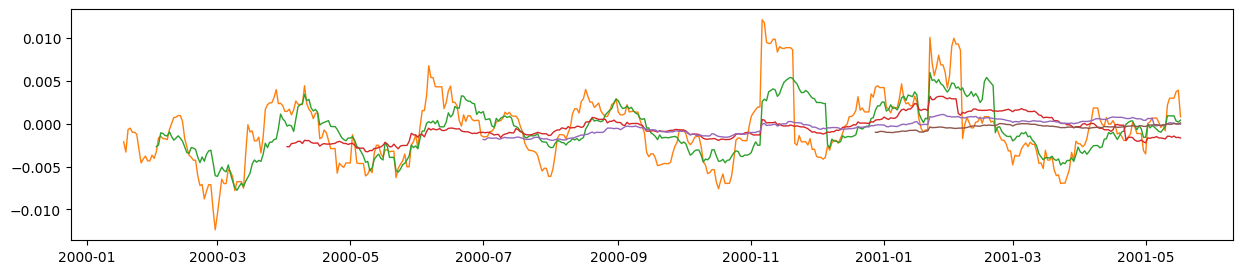

In [12]:
plt.figure(figsize=(15,3))
plt.plot(a[0:500],linewidth=1)

In [14]:
def generate_single_ts(date_range, item_id=None) -> pd.DataFrame:
    """create sum of `n_f` sin/cos curves with random scale and phase."""
    n_f = 2
    period = np.array([24 / (i + 1) for i in range(n_f)]).reshape(1, n_f)
    scale = np.random.normal(1, 0.3, size=(1, n_f))
    phase = 2 * np.pi * np.random.uniform(size=(1, n_f))
    periodic_f = lambda x: scale * np.sin(np.pi * x / period + phase)

    t = np.arange(0, len(date_range)).reshape(-1, 1)
    target = periodic_f(t).sum(axis=1) + np.random.normal(0, 0.1, size=len(t))
    ts = pd.DataFrame({"target": target}, index=date_range)
    if item_id is not None:
        ts["item_id"] = item_id
    return ts

T = 100
date_range = pd.date_range("2021-01-01", periods=T, freq="1D")
N = 100


time_seriess = [generate_single_ts(date_range, item_id=i) for i in range(N)]
time_seriess

[              target  item_id
 2021-01-01  0.485553        0
 2021-01-02  0.177442        0
 2021-01-03 -0.085814        0
 2021-01-04 -0.466120        0
 2021-01-05 -0.663881        0
 ...              ...      ...
 2021-04-06  1.125046        0
 2021-04-07  0.393348        0
 2021-04-08  0.241191        0
 2021-04-09 -0.072671        0
 2021-04-10 -0.517742        0
 
 [100 rows x 2 columns],
               target  item_id
 2021-01-01  0.663854        1
 2021-01-02  0.887265        1
 2021-01-03  0.851165        1
 2021-01-04  0.800057        1
 2021-01-05  0.531341        1
 ...              ...      ...
 2021-04-06  0.501461        1
 2021-04-07  0.863631        1
 2021-04-08  0.996952        1
 2021-04-09  0.791825        1
 2021-04-10  0.971568        1
 
 [100 rows x 2 columns],
               target  item_id
 2021-01-01  0.208918        2
 2021-01-02  0.571826        2
 2021-01-03  1.061789        2
 2021-01-04  1.388003        2
 2021-01-05  1.937807        2
 ...            

In [13]:
print([i.iloc[:-6, :] for i in log_returns["Log Returns"]])

AttributeError: 'float' object has no attribute 'iloc'

In [15]:
ds = PandasDataset(dict(log_returns.iloc[:6000])["Log Returns"])
ds_test = PandasDataset(dict(log_returns.iloc[6000:])["Log Returns"])
ds_mask = PandasDataset(dict(log_returns)["Filled?"])

In [16]:
ds_test

PandasDataset<size=1, freq=D, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [ ]:
def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    plt.figure(figsize=(15,3))
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        plt.figure(figsize=(15,3))
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

In [20]:
mx.gpu(0)

gpu(0)

In [ ]:
log_returns.shape

In [24]:
trainer = Trainer(
    epochs = 1,
    ctx = mx.gpu(0)
)

In [25]:
estimator = TransformerEstimator(
    freq = "1D",
    prediction_length = 6,
    act_type = 'softrelu',
    trainer = trainer
)

In [ ]:
len(ds)

In [26]:
predictor = estimator.train(ds,ds_test)

MXNetError: Traceback (most recent call last):
  File "../include/mxnet/base.h", line 458
CUDA: Check failed: e == cudaSuccess (999 vs. 0) : unknown error

In [ ]:
ds_test

PandasDataset<size=1, freq=D, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds_test, predictor=predictor
)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(tests, forecasts)

Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 1it [00:00,  3.12it/s]


In [ ]:
import itertools

In [ ]:
result = next(itertools.islice(forecast_it,2))

StopIteration: 

In [ ]:
result

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 1.51284586e-03,  9.16097220e-03, -9.58515855e-04,
        -7.18883332e-03,  5.19185327e-03,  1.44721298e-02],
       [ 1.88221652e-02, -7.40916329e-03, -3.58922314e-03,
        -7.12570362e-03,  2.73687728e-02,  4.44529299e-03],
       [-5.68950782e-03,  1.33733742e-03,  5.44955721e-03,
         1.63122395e-03, -1.10783251e-02,  4.60265344e-03],
       [-1.11095363e-03,  4.80914069e-03, -1.53788691e-03,
        -1.03393430e-03,  1.45603772e-04, -2.76473380e-04],
       [ 7.11800857e-03, -6.20907871e-04, -6.49513397e-03,
        -1.33669656e-03, -4.65925084e-03,  2.05090246e-03],
       [ 7.41629582e-03, -6.86018821e-03, -1.07043879e-02,
        -9.37132165e-04,  1.31926026e-06, -6.84107479e-04],
       [-9.56514152e-04,  1.34519227e-02, -2.15675738e-02,
         7.44047295e-03,  1.16053615e-02, -3.95712117e-03],
       [-5.43060340e-03,  6.66761212e-03, -1.29552428e-02,
         3.41353542e-03,  1.81853883e

In [ ]:
len(forecasts)

1

In [ ]:
for i in forecast_it: 
        print(type(i))

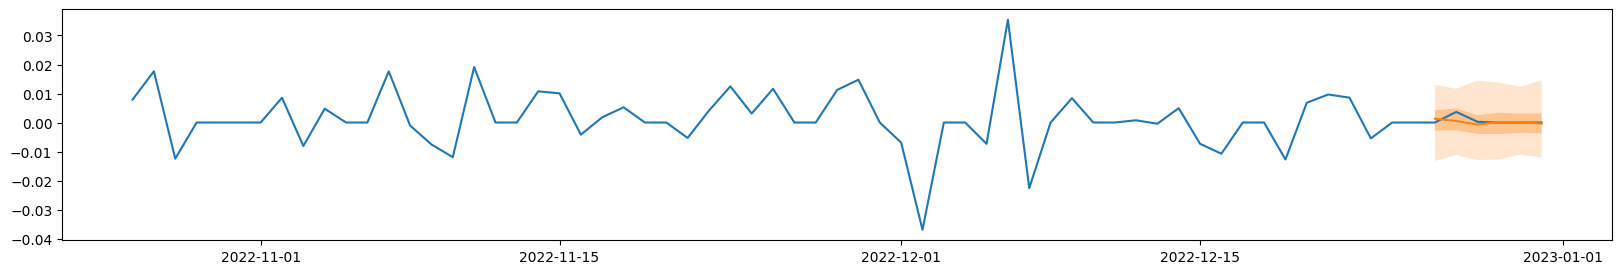

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(tests[0].loc['2022-10-26':'2022-12-31':].to_timestamp())
forecasts[0].plot(show_label=True)

In [ ]:
x = tests[0].loc['2022-11-26':'2022-12-26':]

AttributeError: 'tuple' object has no attribute 'plot'

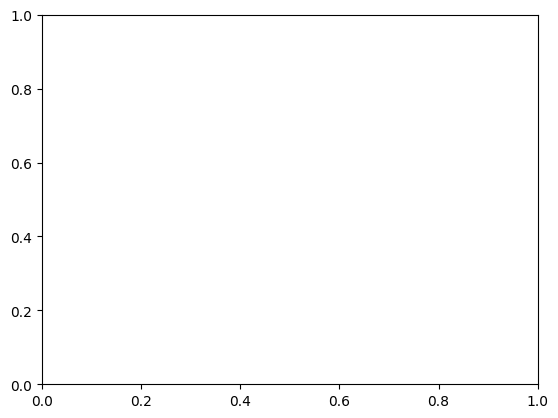

In [ ]:
n_plot = 3
indices = np.random.choice(np.arange(0, 100), size=n_plot, replace=False)

len(tests)

ax = plt.subplots()
plt.plot(x.to_timestamp())
# plt.sca(ax)
ax.plot(forecasts[0])

In [ ]:
with mx.gpu(0):
    x = train_and_predict(ds, estimator)

print(x)

In [ ]:
x["MSE"]

In [ ]:
predictor.serialize(Path(f'{sys.path[0]}/thesis-stuff-mxnet/models'))

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(test))